In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import joblib

In [2]:
# Manually define a list of common English stopwords
stopwords_list = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it',
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
    'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
    'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
    'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren',
    "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
    "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
}

In [3]:
# Load the datasets
train_df = pd.read_csv('E:/train.csv')
test_df = pd.read_csv('E:/test.csv')
sample_submission_df = pd.read_csv('E:/sample_submission.csv')


In [4]:
# Define a text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(word for word in text.split() if word not in stopwords_list)  # Remove stopwords
    return text

In [5]:
# Apply preprocessing to the dataset
train_df['processed_text'] = train_df['full_text'].apply(preprocess_text)
test_df['processed_text'] = test_df['full_text'].apply(preprocess_text)

Missing values in train dataset:
essay_id          0
full_text         0
score             0
processed_text    0
dtype: int64

Missing values in test dataset:
essay_id          0
full_text         0
processed_text    0
dtype: int64


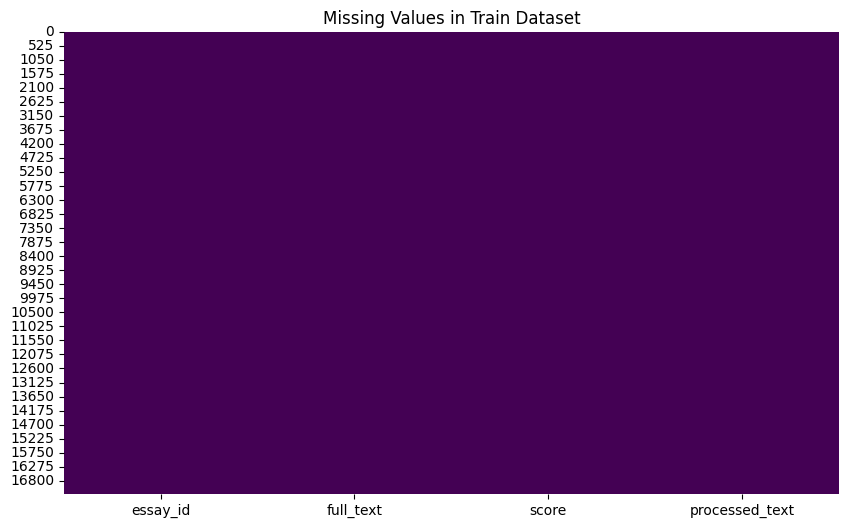

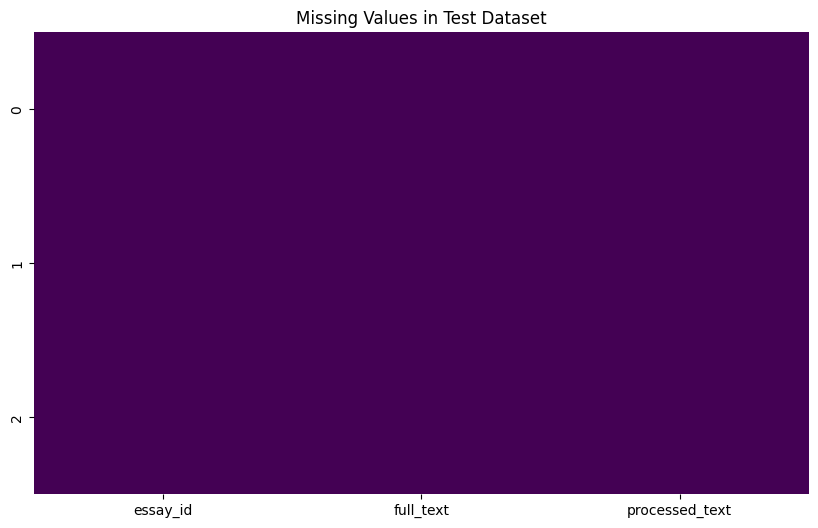

In [6]:
# Missing Data Analysis
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

print("Missing values in train dataset:")
print(missing_values_train)
print("\nMissing values in test dataset:")
print(missing_values_test)

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Train Dataset')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Test Dataset')
plt.show()

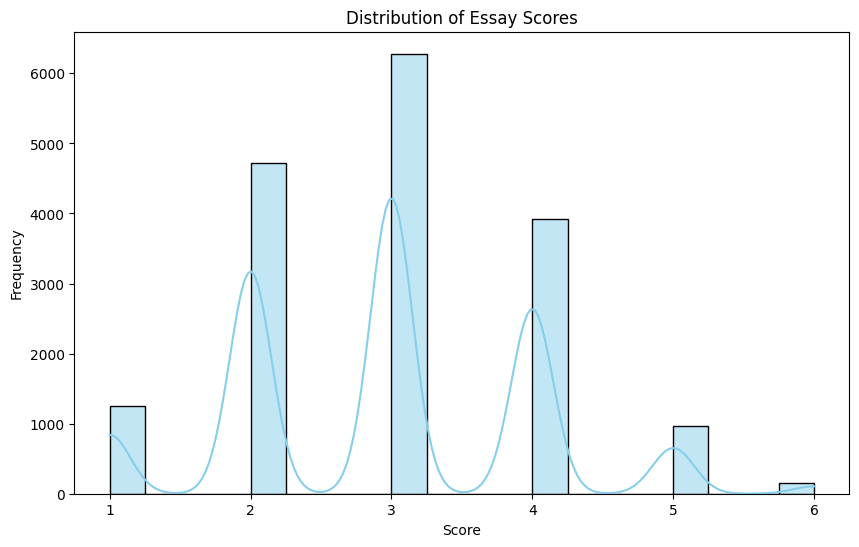

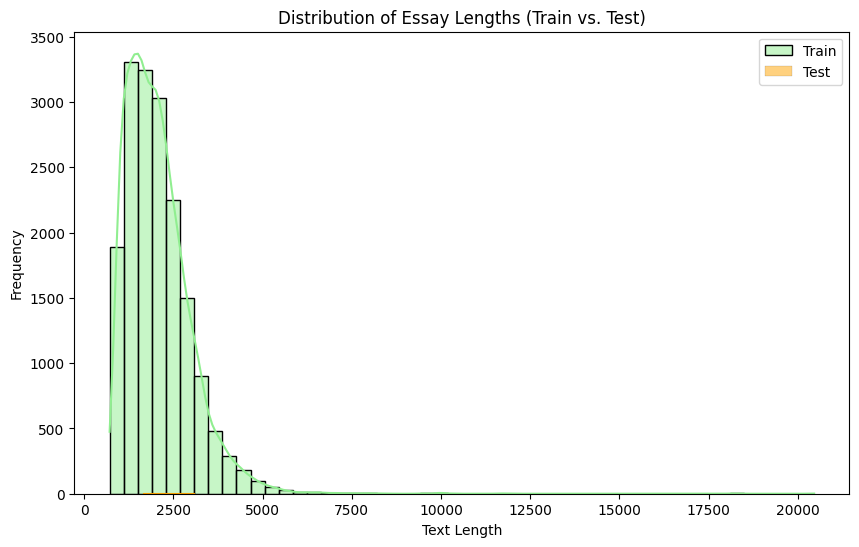

              score   text_length
count  17307.000000  17307.000000
mean       2.948402   2071.617265
std        1.044899    925.910701
min        1.000000    712.000000
25%        2.000000   1397.000000
50%        3.000000   1924.000000
75%        4.000000   2541.000000
max        6.000000  20459.000000


In [7]:
# Univariate Analysis
plt.figure(figsize=(10, 6))
sns.histplot(train_df['score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

train_df['text_length'] = train_df['full_text'].apply(len)
test_df['text_length'] = test_df['full_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='lightgreen', label='Train')
sns.histplot(test_df['text_length'], bins=50, kde=True, color='orange', label='Test')
plt.title('Distribution of Essay Lengths (Train vs. Test)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(train_df.describe())

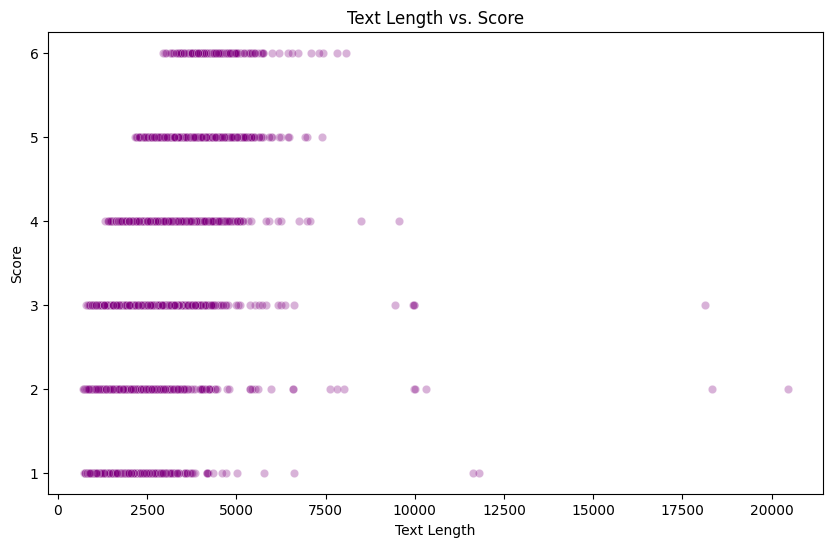

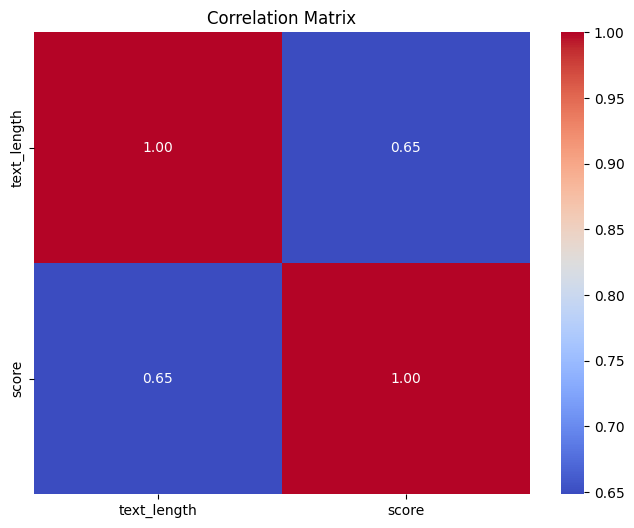

In [8]:
# Bivariate Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='score', data=train_df, alpha=0.3, color='purple')
plt.title('Text Length vs. Score')
plt.xlabel('Text Length')
plt.ylabel('Score')
plt.show()

correlation_matrix = train_df[['text_length', 'score']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

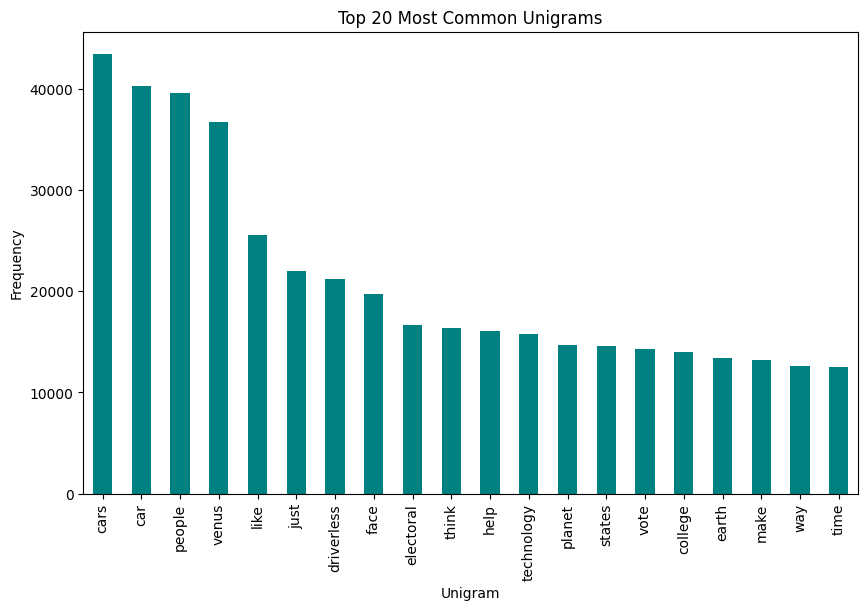

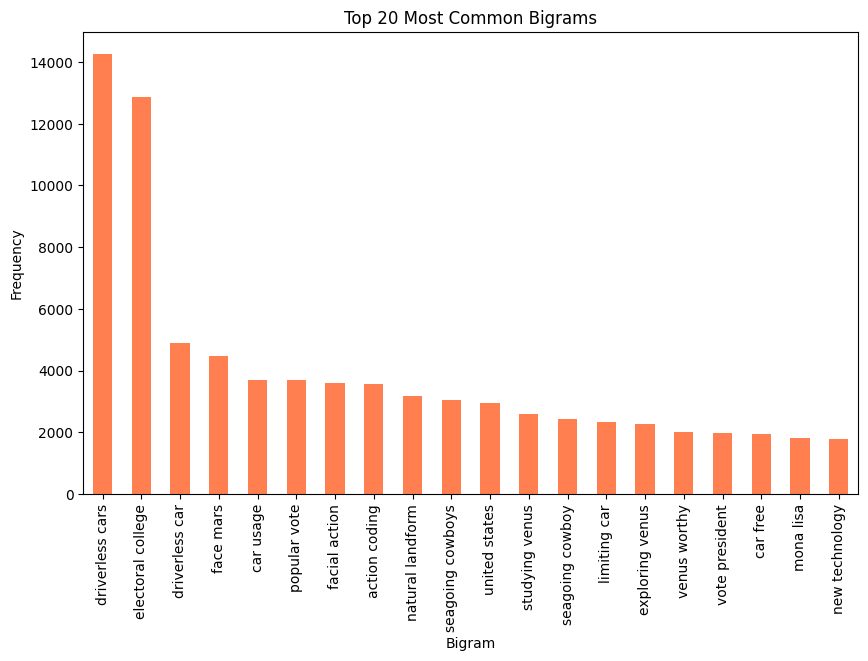

In [9]:
# Text Data Analysis
unigram_vectorizer = CountVectorizer(max_features=20, stop_words='english')
bigram_vectorizer = CountVectorizer(max_features=20, ngram_range=(2, 2), stop_words='english')

unigrams = unigram_vectorizer.fit_transform(train_df['full_text'])
bigrams = bigram_vectorizer.fit_transform(train_df['full_text'])

unigram_df = pd.DataFrame(unigrams.toarray(), columns=unigram_vectorizer.get_feature_names_out())
bigram_df = pd.DataFrame(bigrams.toarray(), columns=bigram_vectorizer.get_feature_names_out())

plt.figure(figsize=(10, 6))
unigram_df.sum().sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Top 20 Most Common Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
bigram_df.sum().sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_df['processed_text'], 
    train_df['score'], 
    test_size=0.2, 
    random_state=42
)

In [11]:
# Create a pipeline with TF-IDF Vectorizer and Gradient Boosting Regressor
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),  # TF-IDF Vectorizer
    ('gbm', GradientBoostingRegressor(random_state=42))  # Gradient Boosting Regressor
])

In [12]:
# Define hyperparameters for Grid Search
param_grid = {
    'tfidf__max_features': [5000, 10000],  # Number of features
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams or unigrams + bigrams
    'gbm__n_estimators': [100, 200],  # Number of boosting stages
    'gbm__learning_rate': [0.01, 0.1],  # Learning rate
    'gbm__max_depth': [3, 5]  # Maximum depth of the individual trees
}

In [13]:
# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000,
                                                        ngram_range=(1, 2))),
                                       ('gbm',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'gbm__learning_rate': [0.01, 0.1],
                         'gbm__max_depth': [3, 5],
                         'gbm__n_estimators': [100, 200],
                         'tfidf__max_features': [5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [14]:
# Output the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_}')

Best Parameters: {'gbm__learning_rate': 0.1, 'gbm__max_depth': 5, 'gbm__n_estimators': 200, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Best Cross-Validation Score: 0.5908426604525215


In [15]:
# Best model from Grid Search
best_model = grid_search.best_estimator_


In [16]:
# Predict on validation set
y_val_pred = best_model.predict(X_val)

In [17]:
# Calculate the validation RMSE
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'Validation RMSE: {rmse}')

Validation RMSE: 0.6500647194375114


C:\Users\Ravishka Madushan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
# Predict scores for the test dataset
test_predictions = best_model.predict(test_df['processed_text'])

In [19]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']